In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import re

import mp_run
import conf_interval

from os import listdir
from os.path import isfile, join
from sklearn.metrics import mean_squared_error, explained_variance_score

import os

from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from scipy import stats

from multiprocessing import Pool, cpu_count


%load_ext autoreload
%autoreload 2

# regex for number extraction from string
number_pattern =  r'(-?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+-]?\d+)?)'

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':200})

In [19]:
res_df_list = [
    pd.read_csv('./yeast_network_v_model.csv', index_col=0),
    pd.read_csv('./bsubtilis_network_v_model.csv', index_col=0),
    pd.read_csv('./arabidopsis_network_v_model.csv', index_col=0),
    pd.read_csv('./mdc_network_v_model.csv', index_col=0)
]

species_names = ['Yeast', 'B.subtilis', 'Arabidopsis', 'Mouse DC']

filtered_df_list = [res_df[res_df['test_std'] > 0.5] for res_df in res_df_list]



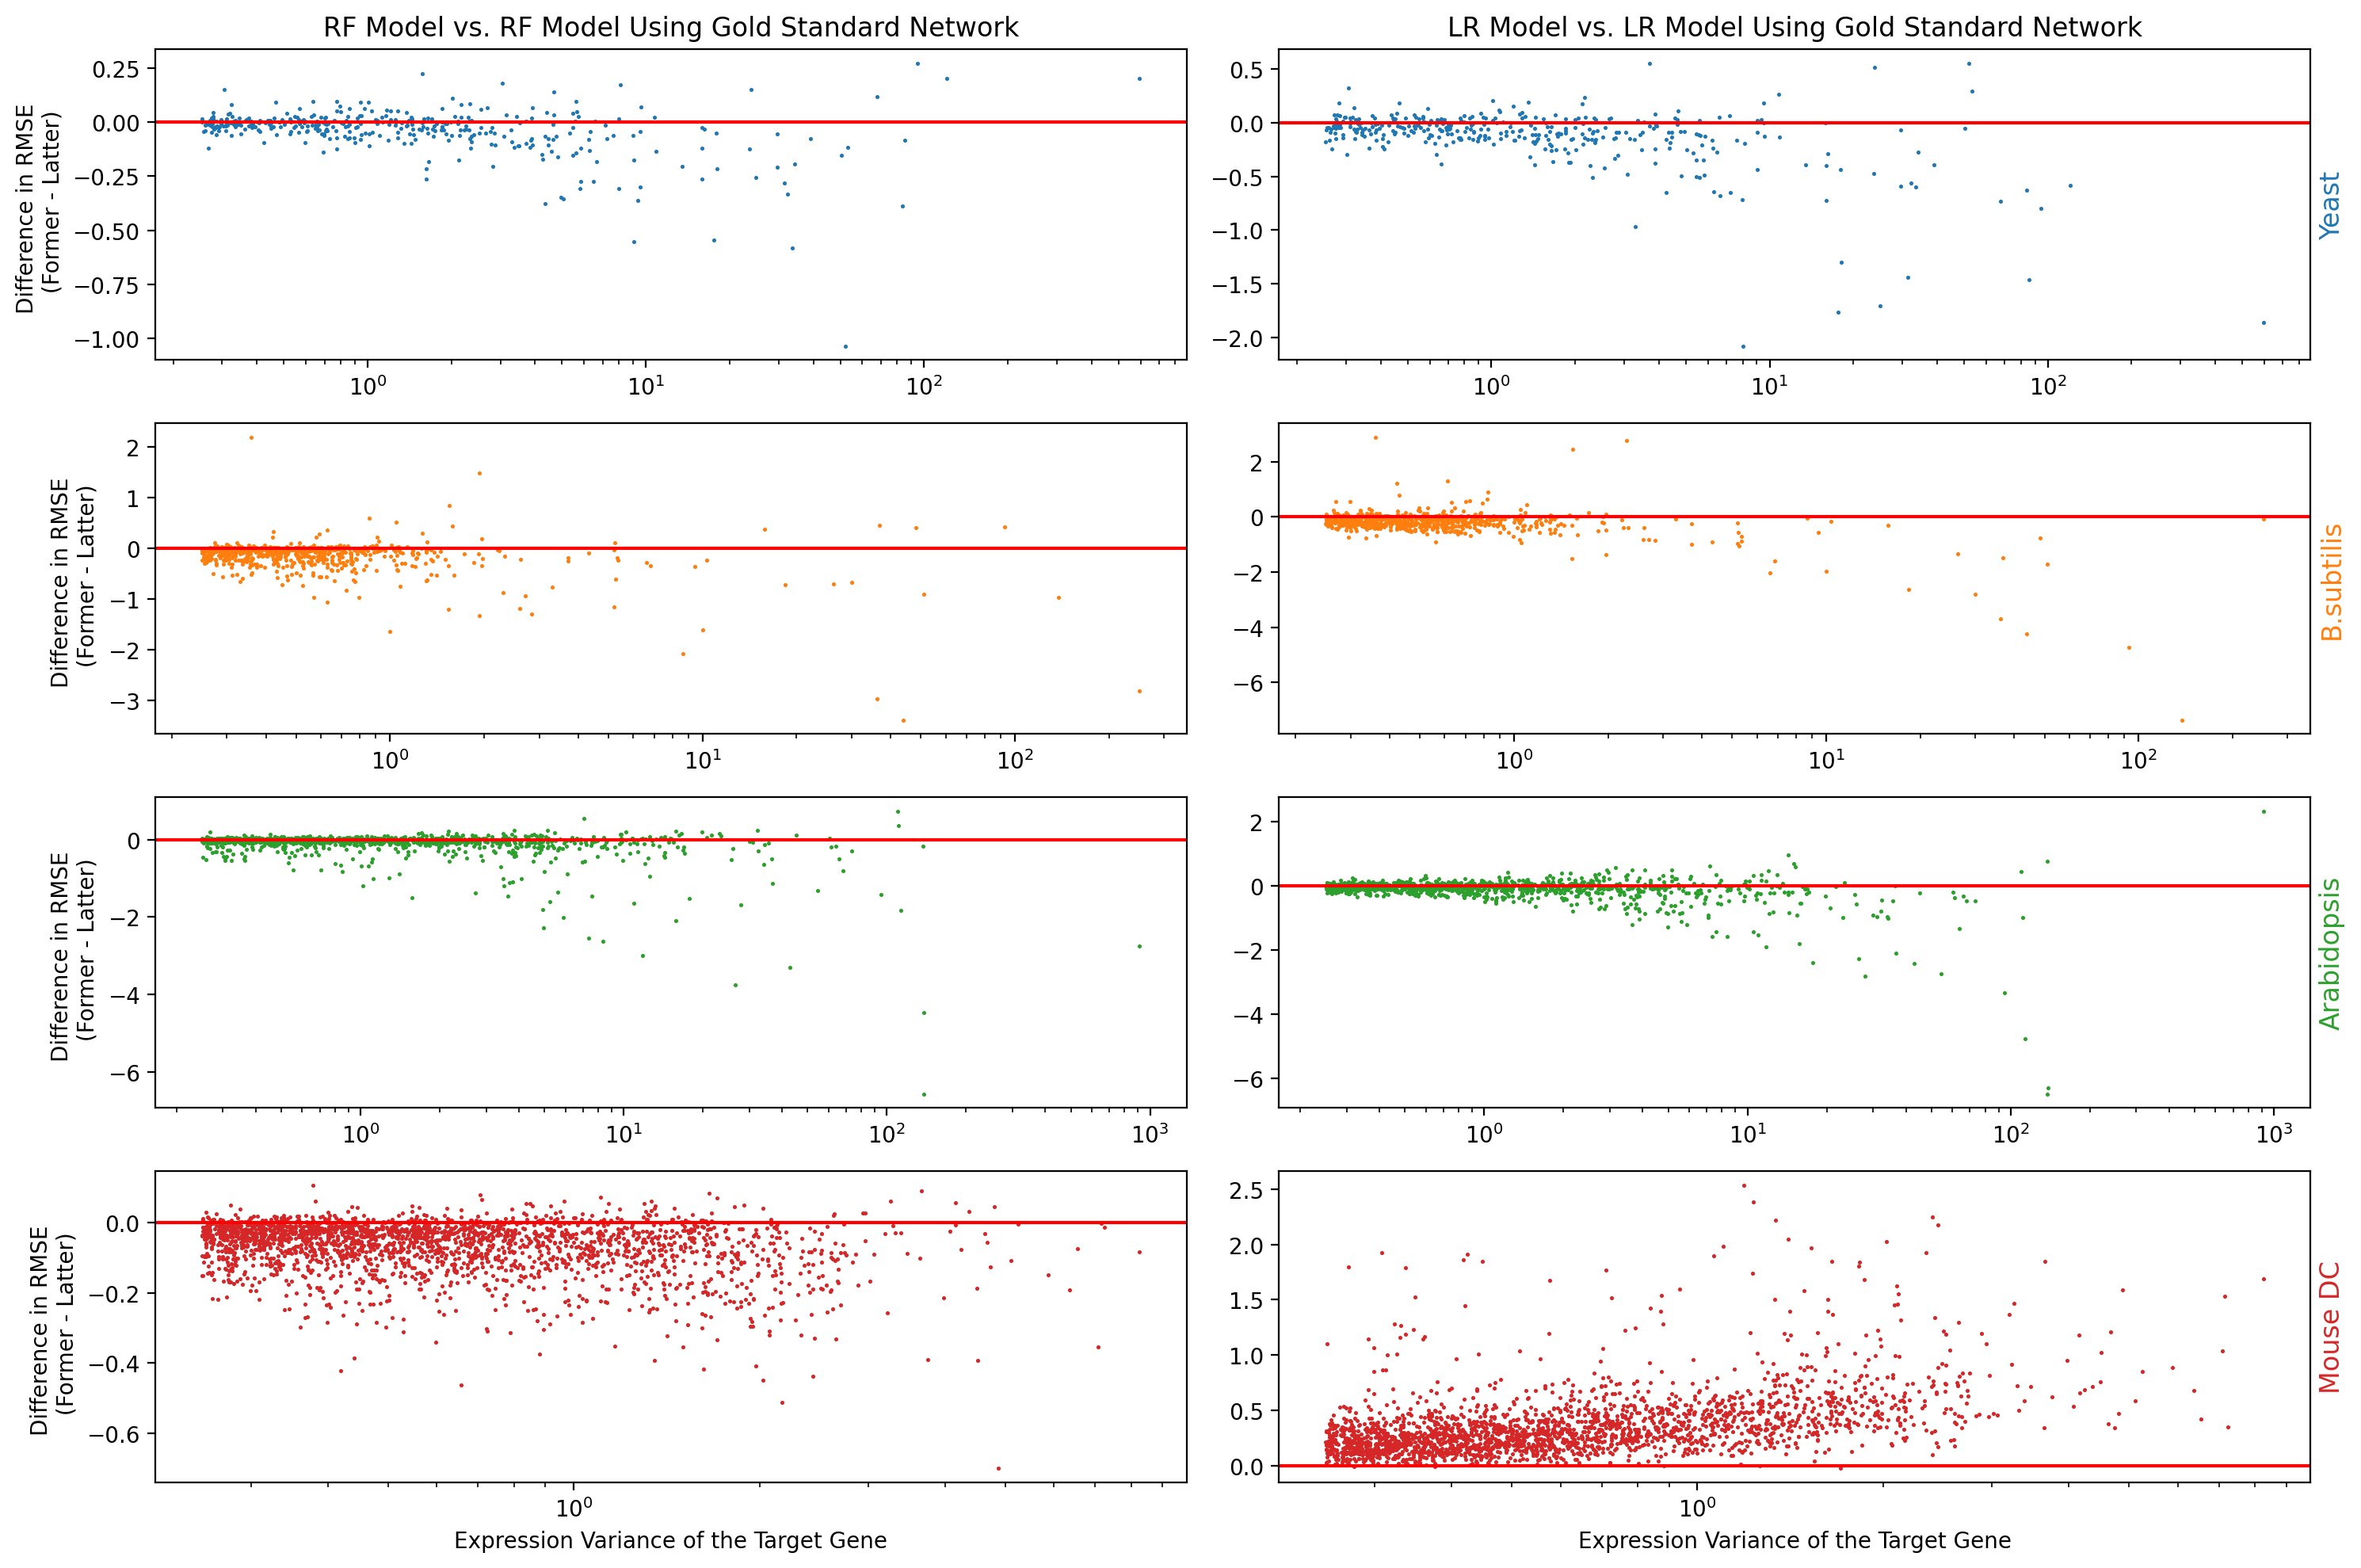

In [3]:
a = 'linear_rmse'
b = 'gs_linear_rmse'
c = 'rf_rmse'
d = 'gs_rf_rmse'

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i in range(4):
    df = filtered_df_list[i]
    diff = df[c] - df[d]
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = df[a] - df[b]
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(4):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[3, 0].set(xlabel='Expression Variance of the Target Gene')
axs[3, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF Model vs. RF Model Using Gold Standard Network')
axs[0, 1].set_title('LR Model vs. LR Model Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/all_v_gs.pdf', format='pdf', dpi=300)

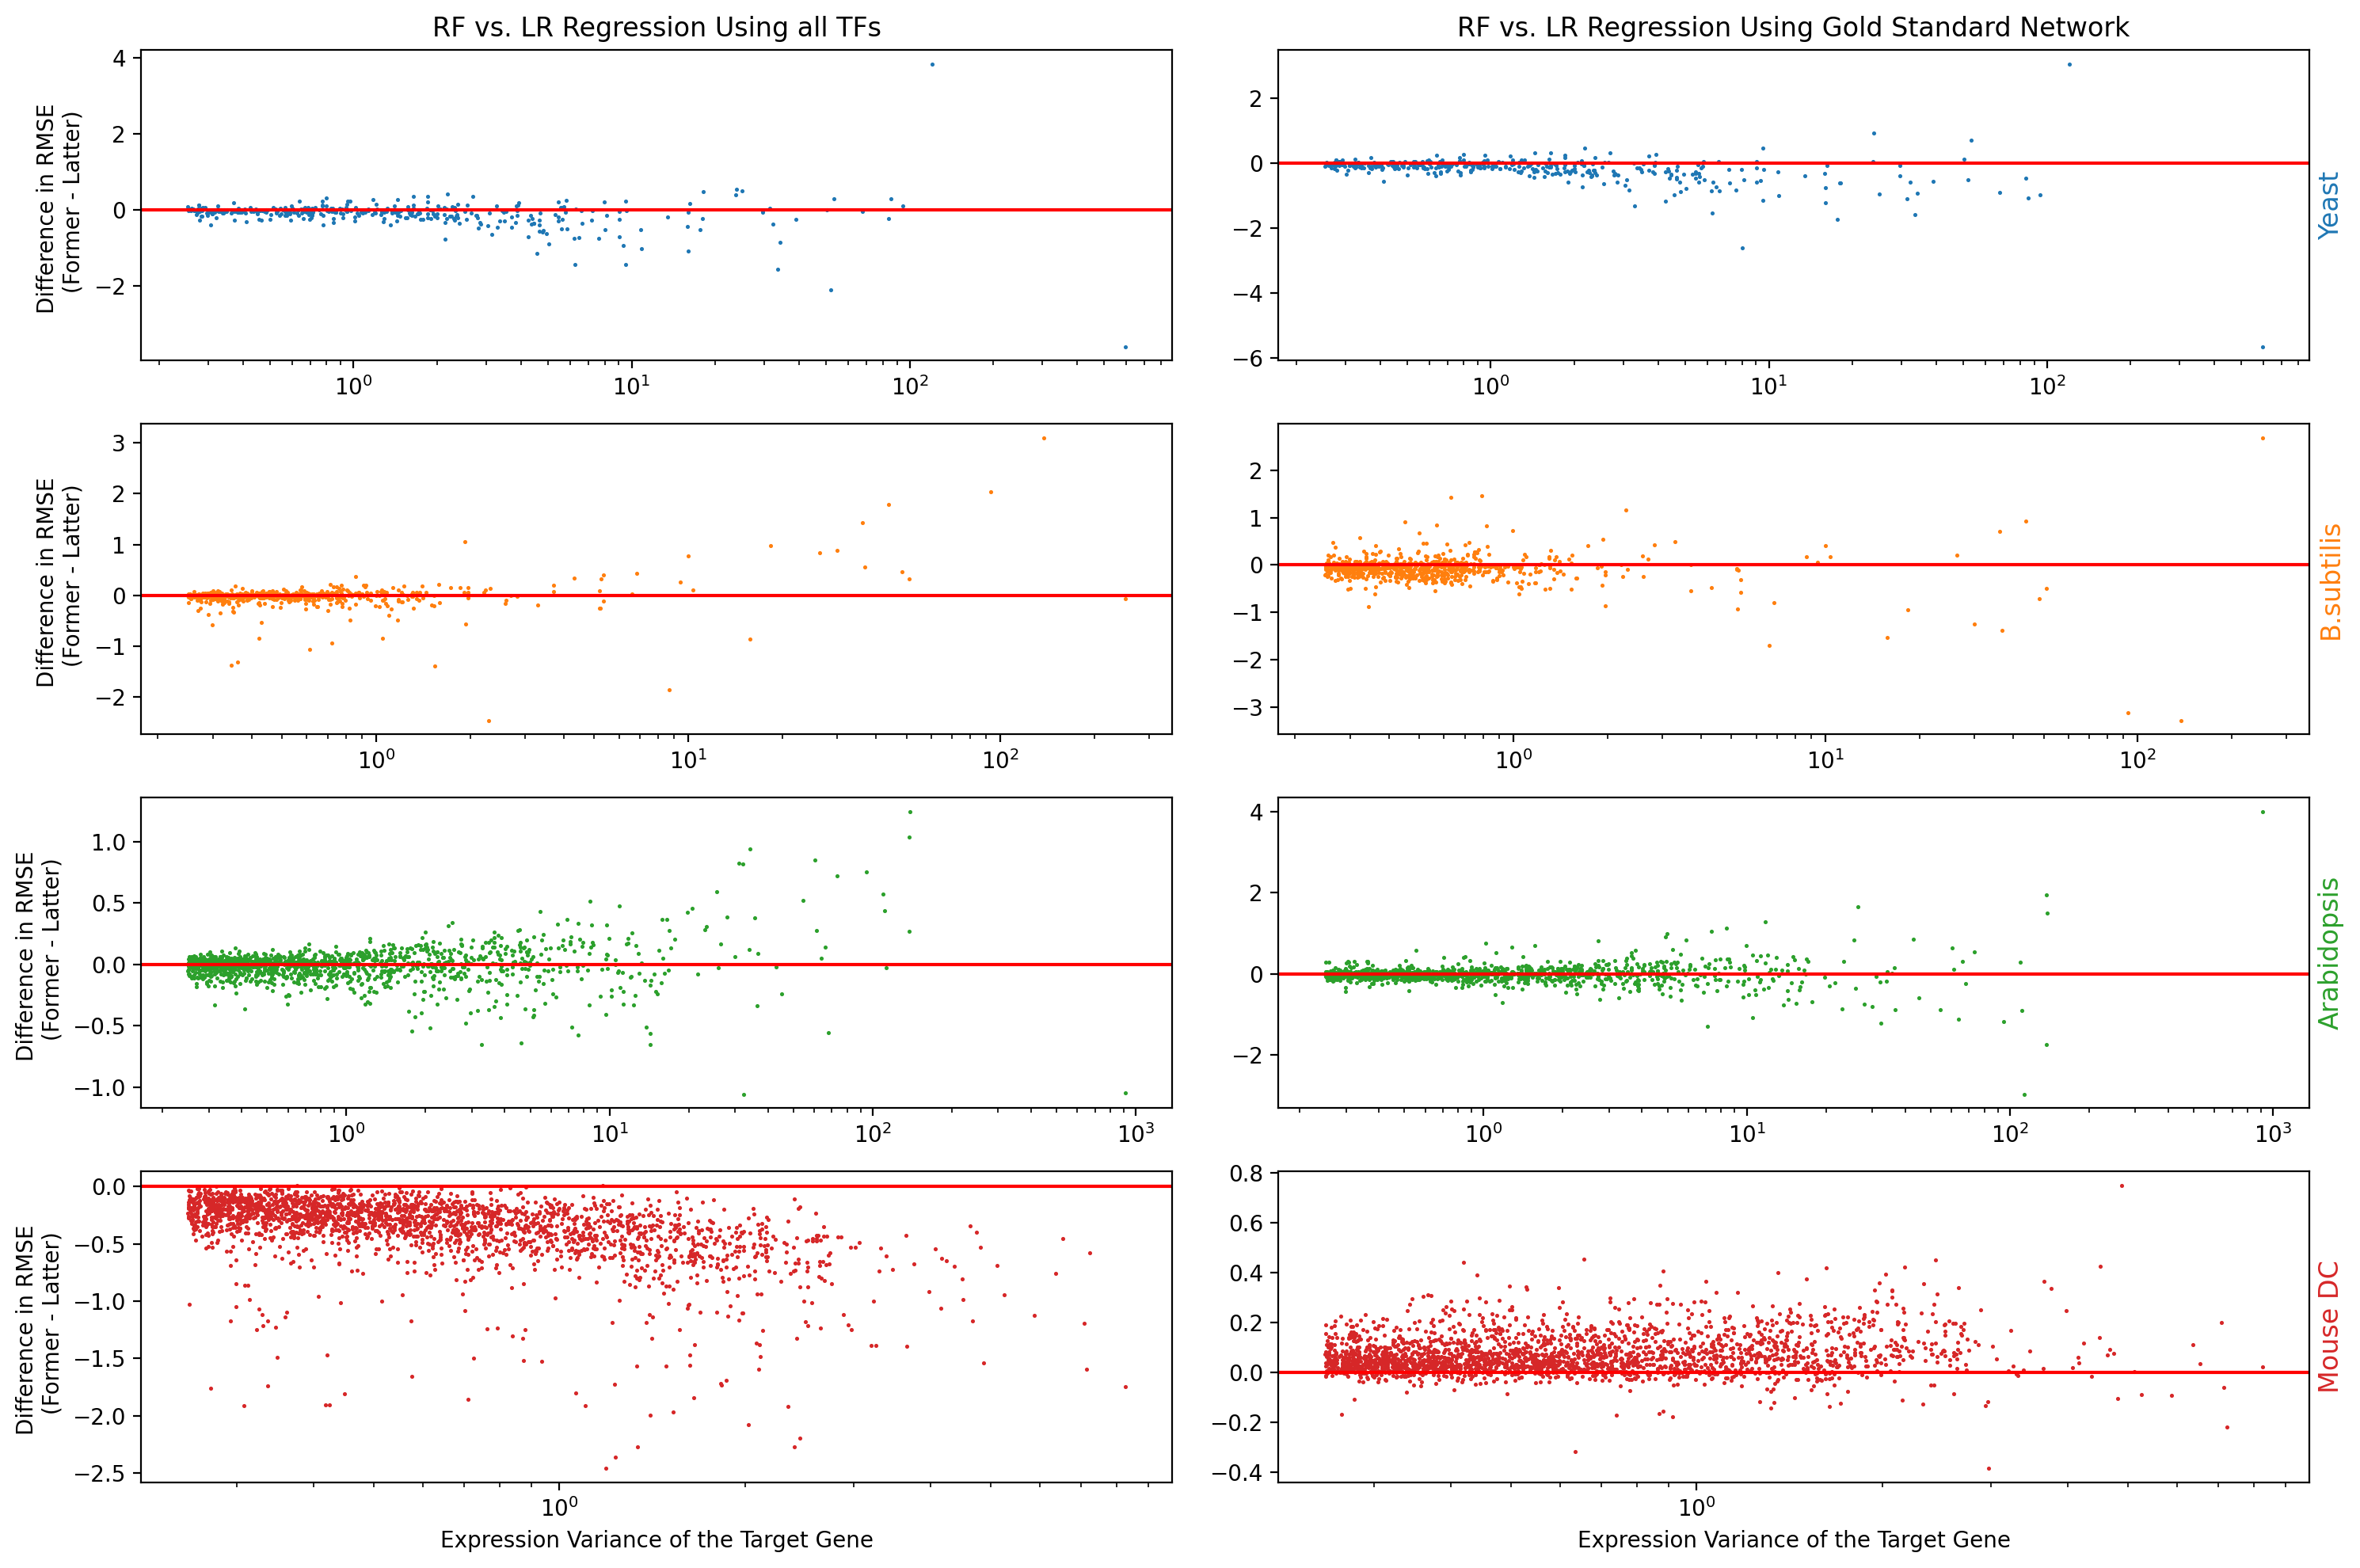

In [4]:
a = 'rf_rmse'
b = 'linear_rmse'
c = 'gs_rf_rmse'
d = 'gs_linear_rmse'

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i in range(4):
    df = filtered_df_list[i]
    diff = df[a] - df[b]
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = df[c] - df[d]
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(4):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[3, 0].set(xlabel='Expression Variance of the Target Gene')
axs[3, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF vs. LR Regression Using all TFs')
axs[0, 1].set_title('RF vs. LR Regression Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/rf_v_lr.pdf', format='pdf', dpi=300)

In [5]:
model_name_dict = {
    'rf_rmse': 'RF with all TFs',
    'linear_rmse': 'LR with all TFs',
    'gs_rf_rmse': 'RF with GS network',
    'gs_linear_rmse': 'LR with GS network',
    'rf_with_top_features_rmse': 'RF with top TFs',
    'linear_with_top_features_rmse': 'LR with top TFs'
}

In [6]:
model_compare_combs = [('rf_rmse', 'gs_rf_rmse'),
 ('linear_rmse', 'gs_linear_rmse'),
 ('rf_rmse', 'linear_rmse'),
 ('gs_rf_rmse', 'gs_linear_rmse'),
 ('rf_rmse', 'gs_linear_rmse'),
 ('gs_rf_rmse', 'linear_rmse')]

In [7]:
top_feature_model_compare_combs = [('rf_with_top_features_rmse', 'rf_rmse'),
 ('rf_with_top_features_rmse', 'gs_rf_rmse'),
 ('linear_with_top_features_rmse', 'linear_rmse'),
 ('linear_with_top_features_rmse', 'gs_linear_rmse')]

In [56]:
paired_ttest_df = pd.DataFrame(index=range(len(model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 1]]

res_df = filtered_df_list[3]

mean_list = []
ci_list = []
p_list = []

stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
for a, b in model_compare_combs:
    t_res = stats.ttest_rel(res_df[a], res_df[b])
    ci_res = t_res.confidence_interval()
    mean = (res_df[a] - res_df[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

paired_ttest_df['Mean Difference'] = mean_list
paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
paired_ttest_df['p-value'] = p_list
paired_ttest_df.to_csv('./plot_output/ttest_res.csv', index=False)

In [60]:
paired_ttest_df = pd.DataFrame(index=range(len(top_feature_model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(top_feature_model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(top_feature_model_compare_combs)[:, 1]]

res_df = filtered_df_list[3]

mean_list = []
ci_list = []
p_list = []

stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
for a, b in top_feature_model_compare_combs:
    t_res = stats.ttest_rel(res_df[a], res_df[b])
    ci_res = t_res.confidence_interval()
    mean = (res_df[a] - res_df[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

paired_ttest_df['Mean Difference'] = mean_list
paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
paired_ttest_df['p-value'] = p_list
paired_ttest_df.to_csv('./plot_output/ttest_res.csv', index=False)
paired_ttest_df

,Model_A,Model_B,Mean Difference,95% Confidence Interval of Difference,p-value
0,RF with top TFs,RF with all TFs,0.0291,"(0.0278, 0.0305)",2.81e-295
1,RF with top TFs,RF with GS network,-0.041,"(-0.0442, -0.0379)",4.61e-129
2,LR with top TFs,LR with all TFs,-0.279,"(-0.29, -0.268)",0.0
3,LR with top TFs,LR with GS network,0.09,"(0.0866, 0.0934)",0.0


In [34]:
edge_stats_list = ['gs_edge_num', 'rf_top_feature_num', 'linear_top_feature_num', 'rf_top_features_gs_overlap', 'linear_top_features_gs_overlap']

In [41]:
edge_stats_df = pd.DataFrame(index=['Gold Standard Network',
                                   'Top Features From RF Regression',
                                   'Top Features From Linear Regression',
                                   'Overlap Between GS and RF Top Features',
                                   'Overlap Between GS and Linear Top Features'])

In [45]:
stats_print_list = []
for df,  species_name in zip(filtered_df_list, species_names):
    stats_print_list = []
    for key in edge_stats_list:
        stats_print = f'{df[key].mean():.3}' + '$\pm$' + f'{df[key].std():.3}'
        stats_print_list.append(stats_print)
    edge_stats_df[species_name] = stats_print_list

In [46]:
edge_stats_df.to_csv('./plot_output/edge_stats.csv')

In [ ]:
f'{filtered_df_list[0]['gs_edge_num'].mean():.3}'

In [31]:
filtered_df_list[3].mean()

rf_score                             -0.086447
linear_score                         -1.282150
gs_rf_score                          -0.281524
gs_linear_score                      -0.078728
rf_with_linear_top_features_score    -0.158380
linear_with_rf_top_features_score    -0.224199
rf_rmse                               0.874537
linear_rmse                           1.241488
gs_rf_rmse                            0.944708
gs_linear_rmse                        0.872783
rf_with_linear_top_features_rmse      0.902169
linear_with_rf_top_features_rmse      0.927581
rf_with_top_features_score           -0.164697
linear_with_top_features_score       -0.328613
rf_with_top_features_rmse             0.903677
linear_with_top_features_rmse         0.962773
rf_top_feature_num                   13.988220
linear_top_feature_num               15.220446
rf_top_features_gs_overlap            0.110644
linear_top_features_gs_overlap        0.122003
rf_linear_top_features_overlap        1.875894
gs_edge_num  

In [95]:
res_df_list[2].mean()

rf_score                             0.156445
linear_score                        -0.075192
gs_rf_score                         -0.057755
gs_linear_score                     -0.010969
rf_with_linear_top_features_score    0.247223
linear_with_rf_top_features_score    0.130521
rf_rmse                              0.138351
linear_rmse                          0.141425
gs_rf_rmse                           0.150264
gs_linear_rmse                       0.152666
rf_with_linear_top_features_rmse     0.134607
linear_with_rf_top_features_rmse     0.137005
rf_top_feature_num                   5.433466
linear_top_feature_num               5.907239
test_var                             0.289295
test_std                             0.181825
rf_with_top_features_score           0.054952
linear_with_top_features_score       0.086126
rf_with_top_features_rmse            0.142191
linear_with_top_features_rmse        0.144937
rf_top_features_gs_overlap           0.744895
linear_top_features_gs_overlap    

In [55]:
filtered_df_list[2]

,rf_score,linear_score,gs_rf_score,gs_linear_score,rf_with_linear_top_features_score,linear_with_rf_top_features_score,rf_rmse,linear_rmse,gs_rf_rmse,gs_linear_rmse,...,test_var,test_std,rf_with_top_features_score,linear_with_top_features_score,rf_with_top_features_rmse,linear_with_top_features_rmse,rf_top_features_gs_overlap,linear_top_features_gs_overlap,gs_edge_num,rf_linear_top_features_overlap
AT5G63600,0.597970,0.752568,0.695101,0.727985,0.662843,0.709871,0.705682,0.553615,0.614551,0.580465,...,1.292538,1.136898,0.314210,0.496534,0.060410,0.051760,2,2,28,0
AT3G49120,0.031100,-0.261725,-0.087841,-0.396367,-0.092440,-0.188681,0.562456,0.641847,0.595980,0.675225,...,0.340707,0.583701,-0.280610,-0.448804,0.047761,0.050801,1,1,4,1
AT1G48380,-0.023041,-0.011245,-0.038729,-0.033525,-0.008557,-0.024680,0.523870,0.520841,0.527872,0.526547,...,0.279922,0.529077,0.040357,-0.094013,0.108914,0.116289,1,3,20,1
AT4G38710,0.382567,0.530099,0.382228,0.439709,0.425338,0.445501,0.573672,0.500463,0.573830,0.546482,...,0.556187,0.745780,-0.172164,0.264079,0.060079,0.047604,0,0,3,1
AT1G66580,0.447006,0.596257,0.550679,0.473741,0.399265,0.678304,1.123361,0.959868,1.012599,1.095870,...,2.381233,1.543124,0.602602,0.580044,0.294722,0.302972,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G53460,0.327008,0.574532,0.380693,0.528052,0.403081,0.505995,2.328433,1.851366,2.233633,1.949871,...,8.406225,2.899349,-1.405638,-0.628697,0.048985,0.040305,1,1,1,2
AT3G03910,0.727868,0.752229,0.474404,-0.257189,0.698145,0.428726,0.293374,0.279934,0.407715,0.630567,...,0.330024,0.574477,-0.962630,-0.540406,0.044232,0.039187,0,0,1,2
AT3G20470,0.618379,0.637976,0.634930,0.486750,0.660763,0.706571,0.671516,0.654047,0.656793,0.778762,...,1.233004,1.110407,-0.089136,-0.120949,0.044060,0.044699,0,0,1,0
AT3G12630,-0.266422,-0.429545,0.041379,-0.300084,-0.319015,-0.289949,0.562932,0.598089,0.489768,0.570365,...,0.261106,0.510985,0.335349,0.005989,0.056521,0.069120,1,2,21,0


In [99]:
filtered_df_list[2][['rf_rmse', 'gs_linear_rmse', 'linear_with_top_features_rmse', 'rf_score', 'gs_linear_score', 'linear_with_top_features_score']]

,rf_rmse,gs_linear_rmse,linear_with_top_features_rmse,rf_score,gs_linear_score,linear_with_top_features_score
AT5G63600,0.705682,0.580465,0.051760,0.597970,0.727985,0.496534
AT3G49120,0.562456,0.675225,0.050801,0.031100,-0.396367,-0.448804
AT1G48380,0.523870,0.526547,0.116289,-0.023041,-0.033525,-0.094013
AT4G38710,0.573672,0.546482,0.047604,0.382567,0.439709,0.264079
AT1G66580,1.123361,1.095870,0.302972,0.447006,0.473741,0.580044
...,...,...,...,...,...,...
AT5G53460,2.328433,1.949871,0.040305,0.327008,0.528052,-0.628697
AT3G03910,0.293374,0.630567,0.039187,0.727868,-0.257189,-0.540406
AT3G20470,0.671516,0.778762,0.044699,0.618379,0.486750,-0.120949
AT3G12630,0.562932,0.570365,0.069120,-0.266422,-0.300084,0.005989


In [94]:
filtered_df_list[2].mean()

rf_score                             0.390678
linear_score                         0.378474
gs_rf_score                          0.297953
gs_linear_score                      0.277252
rf_with_linear_top_features_score    0.398570
linear_with_rf_top_features_score    0.396999
rf_rmse                              0.890910
linear_rmse                          0.868097
gs_rf_rmse                           0.963142
gs_linear_rmse                       0.976911
rf_with_linear_top_features_rmse     0.876418
linear_with_rf_top_features_rmse     0.857943
rf_top_feature_num                   4.590677
linear_top_feature_num               5.907502
test_var                             3.747923
test_std                             1.276839
rf_with_top_features_score           0.065052
linear_with_top_features_score       0.102125
rf_with_top_features_rmse            0.132806
linear_with_top_features_rmse        0.134898
rf_top_features_gs_overlap           0.755280
linear_top_features_gs_overlap    

In [92]:
t_res = stats.ttest_rel(filtered_df_list[3]['rf_with_top_features_rmse'], filtered_df_list[3]['rf_rmse'])

In [93]:
t_res.confidence_interval()

ConfidenceInterval(low=-0.30247784744499917, high=-0.2625056607127292)

In [ ]:
stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
for a, b in top_feature_model_compare_combs:
    t_res = stats.ttest_rel(res_df[a], res_df[b])
    ci_res = t_res.confidence_interval()
    mean = (res_df[a] - res_df[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

In [ ]:
r = np.array(r)
out_df = pd.DataFrame(index=target_gene_list)
out_df['rf_score'] = r[:, 0]
out_df['linear_score'] = r[:, 1]
out_df['gs_rf_score'] = r[:, 2]
out_df['gs_linear_score'] = r[:, 3]
out_df['rf_with_linear_top_features_score'] = r[:, 4]
out_df['linear_with_rf_top_features_score'] = r[:, 5]
out_df['rf_rmse'] = r[:, 6]
out_df['linear_rmse'] = r[:, 7]
out_df['gs_rf_rmse'] = r[:, 8]
out_df['gs_linear_rmse'] = r[:, 9]
out_df['rf_with_linear_top_features_rmse'] = r[:, 10]
out_df['linear_with_rf_top_features_rmse'] = r[:, 11]
out_df['rf_with_top_features_score'] = r[:, 12]
out_df['linear_with_top_features_score'] = r[:, 13]
out_df['rf_with_top_features_rmse'] = r[:, 14]
out_df['linear_with_top_features_rmse'] = r[:, 15]
out_df['rf_top_feature_num'] = r[:, 16]
out_df['linear_top_feature_num'] = r[:, 17]
out_df['rf_top_features_gs_overlap'] = r[:, 18]
out_df['linear_top_features_gs_overlap'] = r[:, 19]
out_df['rf_linear_top_features_overlap'] = r[:, 20]
out_df['gs_edge_num'] = r[:, 21]
out_df['test_var'] = r[:, 22]
out_df['test_std'] = r[:, 23]